In [1]:
%matplotlib inline

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

# Input: none.
# Output: filter_x and filter_y are 3×3 filters that differentiate along x and y directions, respectively.
# Description: You will compute the gradient by differentiating the image along x and
# y directions. This code will output the differential filters.
def get_differential_filter():
    # To do
    filter_x = np.array([[1,0,-1], [1,0,-1], [1,0,-1]])
    filter_y = np.array([[1,1,1], [0,0,0], [-1,-1,-1]])
    return filter_x, filter_y

# Input: im is the gray scale m × n image (Figure 2(a)) converted to float format and
# filter is a filter (k × k matrix)
# Output: im_filtered is m × n filtered image. You may need to pad zeros on the
# boundary on the input image to get the same size filtered image.
# Description: Given an image and filter, you will compute the filtered image. Given the
# two functions above, you can generate differential images by visualizing the magnitude
# of the filter response as shown in Figure 2(b) and 2(c).
def filter_image(im, filter):
    # To do
    im_filtered = np.zeros_like(im, dtype="float64")

    filter_length = len(filter)
    height, width = im.shape
#     print(height, " x ", width)

    # for i in range(height):
    #     for j in range(width):

    for i in range(height):
        for j in range(width):
            sum = 0
            for k in range(filter_length*filter_length):
                y = math.floor(k/filter_length)
                x = k%filter_length

                pixel_y = i+y-(filter_length//2)
                pixel_x = j+x-(filter_length//2)
                current_pixel_value = 0

                if not (pixel_y < 0 or pixel_y >= height or pixel_x < 0 or pixel_x >= width):
                    current_pixel_value = im[pixel_y][pixel_x]
                sum += filter[y][x] * current_pixel_value;

            im_filtered[i][j] = sum
#     print(np.unique(im_filtered))
    return im_filtered

# Input: im_dx and im_dy are the x and y differential images (size: m × n).
# Output: grad_mag and grad_angle are the magnitude and orientation of the gradient
# images (size: m × n). Note that the range of the angle should be [0, π), i.e., unsigned
# angle (θ == θ + π).
# Description: Given the differential images, you will compute the magnitude and angle
# of the gradient. Using the gradients, you can visualize and have some sense with the
# image, i.e., the magnitude of the gradient is proportional to the contrast (edge) of the local patch and the orientation is perpendicular to the edge direction as shown in Figure 3.
def get_gradient(im_dx, im_dy):
    # To do
    grad_mag = np.zeros_like(im_dx, dtype="float64")
    grad_angle = np.zeros_like(im_dx, dtype="float64")
    for i in range(np.size(im_dx, 0)):
        for j in range(np.size(im_dx, 1)):
#             try:
            grad_angle[i, j] = np.arctan2(im_dy[i,j], im_dx[i,j])
            if grad_angle[i,j] < 0:
                grad_angle[i,j] = np.pi + grad_angle[i,j]
            grad_angle[i,j] = np.degrees(grad_angle[i,j])
            grad_mag[i,j] = np.sqrt(im_dx[i,j]**2+im_dy[i,j]**2)
#     cv2.imwrite("heatmap.png", cv2.applyColorMap(grad_angle, cv2.COLORMAP_JET))
#     for i in grad_angle:
#         print(grad_angle)
    return grad_mag, grad_angle


def build_histogram(grad_mag, grad_angle, cell_size):
    # To do
    height, width = grad_mag.shape
    m = int(np.floor(height/cell_size))
    n = int(np.floor(width/cell_size))
#     print(m)
#     print(n)
    ori_histo = np.zeros((m, n, 6), dtype="float64")
    
    for i in range(m * cell_size):
        for j in range(n * cell_size):
            h = int(np.floor(i/cell_size))
            w = int(np.floor(j/cell_size))
            if grad_angle[i, j] >= 165 or grad_angle[i,j] < 15:
                ori_histo[h, w, 0] = ori_histo[h, w, 0] + grad_mag[i, j]
            elif grad_angle[i, j] < 45:
                ori_histo[h, w, 1] = ori_histo[h, w, 1] + grad_mag[i, j]
            elif grad_angle[i,j] < 75:
                ori_histo[h, w, 2] = ori_histo[h, w, 2] + grad_mag[i, j]
            elif grad_angle[i,j] < 105:
                ori_histo[h, w, 3] = ori_histo[h, w, 3] + grad_mag[i, j]    
            elif grad_angle[i,j] < 135:
                ori_histo[h, w, 4] = ori_histo[h, w, 4] + grad_mag[i, j]
            elif grad_angle[i,j] < 165:
                ori_histo[h, w, 5] = ori_histo[h, w, 5] + grad_mag[i, j]   
#     print(ori_histo)
    return ori_histo



def get_block_descriptor(ori_histo, block_size):
    # To do
    height, width, depth = ori_histo.shape
    ori_histo_normalized = np.zeros((height - block_size + 1, width - block_size + 1, 6 * block_size**2))
    height, width, depth = ori_histo_normalized.shape
    for i in range(height):
        for j in range(width):
            sum = 0
            for l in range(block_size):
                for m in range(block_size):
                    for n in range(6):
                        sum += (ori_histo[i+l, j+m, n])**2
            sum = np.sqrt(sum + .001**2)
            for k in range(6 * block_size**2):
                ori_histo_normalized[i, j, k] = ori_histo[i+int(k/6)%block_size, j+int(int(k/6)/block_size), k%6]/sum
    return ori_histo_normalized
                


def extract_hog(im):
    # convert grey-scale image to double format
    im = im.astype('float') / 255.0
    # To do
    filter_x, filter_y = get_differential_filter()
    x_filtered = filter_image(im, filter_x)
    y_filtered = filter_image(im, filter_y)
    gradient_mag, gradient_angle = get_gradient(x_filtered, y_filtered)
    HOG1 = build_histogram(gradient_mag, gradient_angle, 8)
    HOG_normal = get_block_descriptor(HOG1, 2)
#     print(np.shape(HOG_normal))
    hog = HOG_normal.flatten()
    # visualize to verify
    visualize_hog(im, hog, 8, 2)
    return hog


# visualize histogram of each block
def visualize_hog(im, hog, cell_size, block_size):
    num_bins = 6
    max_len = 7  # control sum of segment lengths for visualized histogram bin of each block
    im_h, im_w = im.shape
    num_cell_h, num_cell_w = int(im_h / cell_size), int(im_w / cell_size)
    num_blocks_h, num_blocks_w = num_cell_h - block_size + 1, num_cell_w - block_size + 1
    histo_normalized = hog.reshape((num_blocks_h, num_blocks_w, block_size**2, num_bins))
    histo_normalized_vis = np.sum(histo_normalized**2, axis=2) * max_len  # num_blocks_h x num_blocks_w x num_bins
    angles = np.arange(0, np.pi, np.pi/num_bins)
    mesh_x, mesh_y = np.meshgrid(np.r_[cell_size: cell_size*num_cell_w: cell_size], np.r_[cell_size: cell_size*num_cell_h: cell_size])
    mesh_u = histo_normalized_vis * np.sin(angles).reshape((1, 1, num_bins))  # expand to same dims as histo_normalized
    mesh_v = histo_normalized_vis * -np.cos(angles).reshape((1, 1, num_bins))  # expand to same dims as histo_normalized
    plt.imshow(im, cmap='gray', vmin=0, vmax=1)
    for i in range(num_bins):
        plt.quiver(mesh_x - 0.5 * mesh_u[:, :, i], mesh_y - 0.5 * mesh_v[:, :, i], mesh_u[:, :, i], mesh_v[:, :, i],
                   color='red', headaxislength=0, headlength=0, scale_units='xy', scale=1, width=0.002, angles='xy')
    plt.show()
    # plt.savefig('test.png')

def face_recognition(I_target, I_template):
    temp_list = []
    
    hog_template = extract_hog(I_template)
    height, width = np.shape(I_target)
    height_temp, width_temp = np.shape(I_template)
    
    temp_norm = 0
    
#     for i in hog_template:
#         temp_norm += i**2
    temp_norm = np.linalg.norm(hog_template)
    
    dot_sum = 0
    tar_norm = 0
    
#     counter = 0
    for i in range(0, height-height_temp,3):
        for j in range(0, width-width_temp,5):
            print(i, j)
#             if not (i+height_temp >= height or j+width_temp >= width):
            subimage = I_target[i:i+height_temp, j:j+width_temp]
            hog_sub = extract_hog(subimage)
            dot_prod = np.dot(hog_template, hog_sub)
            denominator = np.linalg.norm(hog_template) * np.linalg.norm(hog_sub)
            if dot_prod/denominator >= .65:
                temp_list.append([j, i, dot_prod/denominator])
                    
    bounding_boxes = np.array(temp_list)
    
#     for i in bounding_boxes

    return bounding_boxes


def visualize_face_detection(I_target,bounding_boxes,box_size):

    hh,ww,cc=I_target.shape

    fimg=I_target.copy()
    for ii in range(bounding_boxes.shape[0]):

        x1 = bounding_boxes[ii,0]
        x2 = bounding_boxes[ii, 0] + box_size
        y1 = bounding_boxes[ii, 1]
        y2 = bounding_boxes[ii, 1] + box_size

        if x1<0:
            x1=0
        if x1>ww-1:
            x1=ww-1
        if x2<0:
            x2=0
        if x2>ww-1:
            x2=ww-1
        if y1<0:
            y1
        if y1>hh-1:
            y1=hh-1
        if y2<0:
            y2=0
        if y2>hh-1:
            y2=hh-1
        fimg = cv2.rectangle(fimg, (int(x1),int(y1)), (int(x2),int(y2)), (255, 0, 0), 1)
        cv2.putText(fimg, "%.2f"%bounding_boxes[ii,2], (int(x1)+1, int(y1)+2), cv2.FONT_HERSHEY_SIMPLEX , 0.5, (0, 255, 0), 2, cv2.LINE_AA)


    plt.figure(3)
    plt.imshow(fimg, vmin=0, vmax=1)
    plt.show()



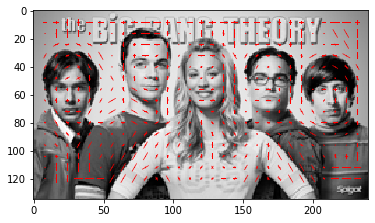

asdf


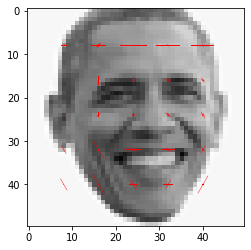

0 0


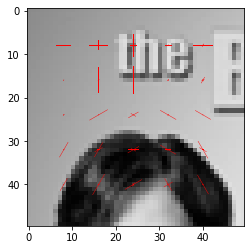

0 5


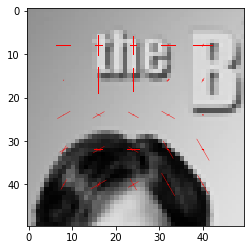

0 10


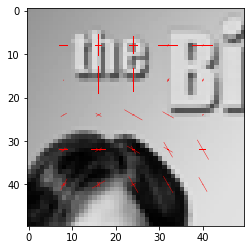

0 15


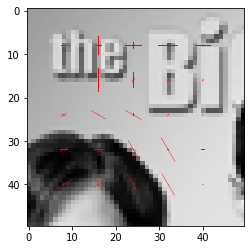

0 20


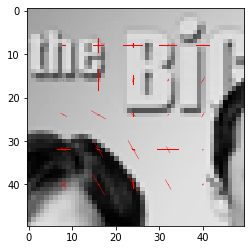

0 25


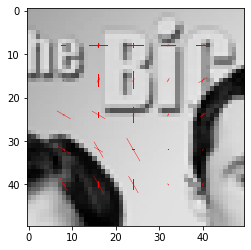

0 30


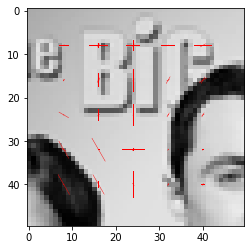

0 35


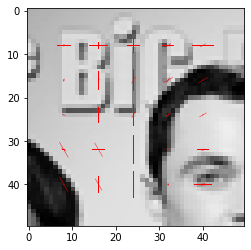

0 40


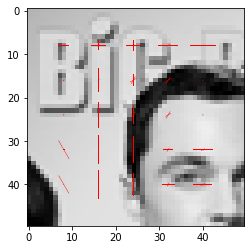

0 45


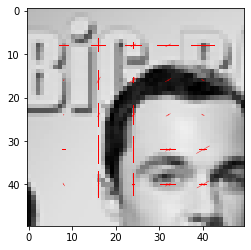

0 50


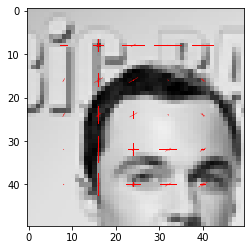

0 55


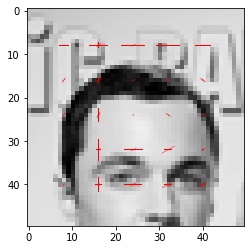

0 60


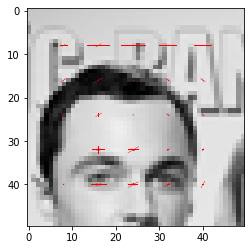

0 65


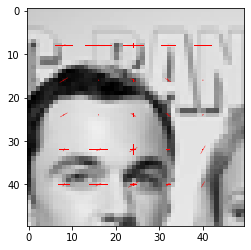

0 70


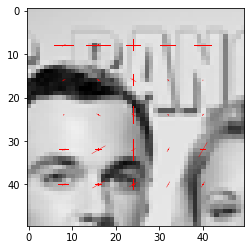

0 75


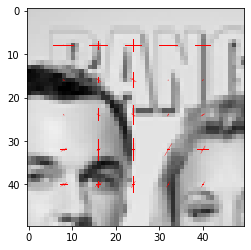

0 80


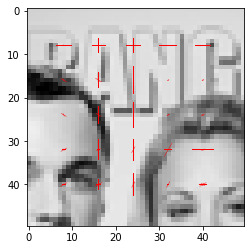

0 85


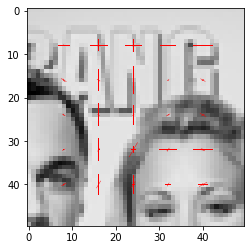

0 90


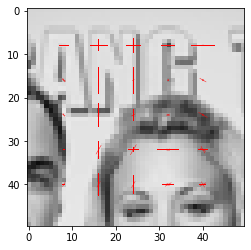

0 95


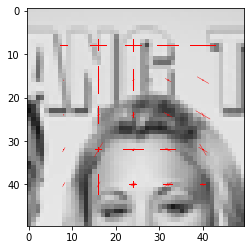

0 100


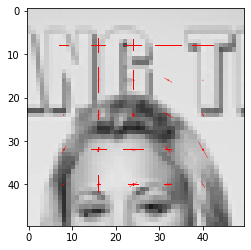

0 105


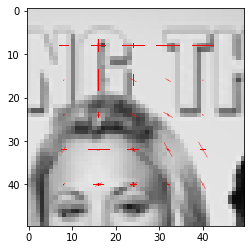

0 110


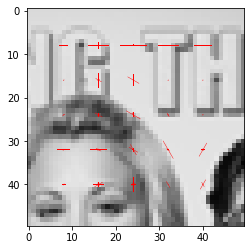

0 115


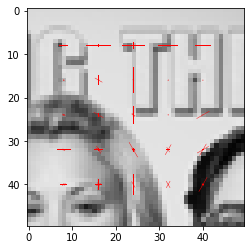

0 120


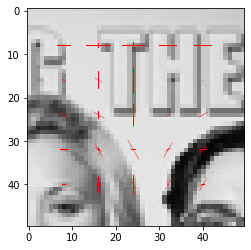

0 125


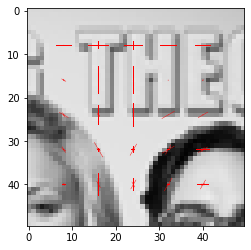

0 130


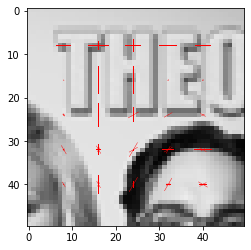

0 135


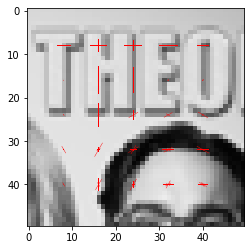

0 140


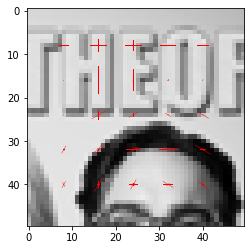

0 145


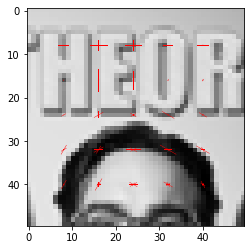

0 150


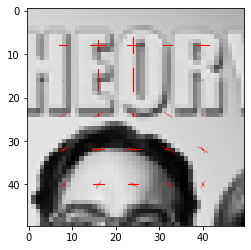

0 155


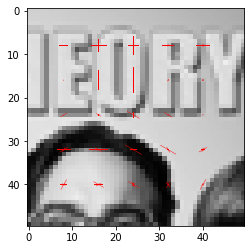

0 160


KeyboardInterrupt: 

In [3]:
# if __name__=='__main__':
#     print("asdf")
# real stuff below
im1 = cv2.imread('target.png', 0)
im2 = cv2.imread('template.png', 0)
im3 = cv2.imread('target.png')
hog1 = extract_hog(im1)
# hog2 = extract_hog(im2)
print("asdf")
bounding_boxes = face_recognition(im1, im2)
print(bounding_boxes)
visualize_face_detection(im3,bounding_boxes,50)

#     vector = extract_hog(im)
#     filter_x, filter_y = get_differential_filter()
#     x_filtered = filter_image(im, filter_x)
#     y_filtered = filter_image(im, filter_y)
# #     print(x_filtered)
# #     print(y_filtered)
#     gradient_mag, gradient_angle = get_gradient(x_filtered, y_filtered)
#     HOG1 = build_histogram(gradient_mag, gradient_angle, 8)
#     HOG_normal = get_block_descriptor(HOG1, 2)

    # hog = extract_hog(im)
    #
    # I_target= cv2.imread('target.png', 0)
    # #MxN image
    #
    # I_template = cv2.imread('template.png', 0)
    # #mxn  face template
    #
    # bounding_boxes=face_recognition(I_target, I_template)
    #
    # I_target_c= cv2.imread('target.png')
    # # MxN image (just for visualization)
    # visualize_face_detection(I_target_c, bounding_boxes, template.shape[0])
    # #this is visualization code.


In [ ]:
def get_intersection(x1, y1, x2, y2):
    x_diff = 50 - np.abs(x2-x1)
    y_diff = 50 - np.abs(y2-y1)
#     print(x_diff*y_diff/(5000-x_diff*y_diff))
#     print(x_diff, y_diff)
    if x_diff < 0 or y_diff < 0:
        return False
    return x_diff*y_diff/(5000-x_diff*y_diff) > .3

filtered_boxes = []

temp = bounding_boxes

while temp.size != 0:
    biggest = np.argmax(temp[:,2])
    y_val = temp[biggest, 0]
    x_val = temp[biggest, 1]
#     print(temp[biggest,:])
    filtered_boxes.append(temp[biggest,:])
    temp = np.delete(temp, biggest, 0)
    i = 0
    while i < np.size(temp, 0):
        y_val_2 = temp[i, 0]
        x_val_2 = temp[i, 1]
        print(x_val, y_val, x_val_2, y_val_2)
#         i += 1
#         get_intersection(x_val, y_val, x_val_2, y_val_2)
#         print(x_val_2, y_val_2)
#         i += 1
        if get_intersection(x_val, y_val, x_val_2, y_val_2):
            print(temp[i,:])
            temp = np.delete(temp, i, 0)
        else:
            i += 1

# print(temp)
# print("filtered")
filtered_boxes = np.array(filtered_boxes)
while i < np.size(filtered_boxes, 0):
    if filtered_boxes[i, 1] > 70:
        filtered_boxes = np.delete(filtered_boxes, i, 0)
    i+=1
    
print(filtered_boxes)
# print(np.size(filtered_boxes, 0))
visualize_face_detection(im3,filtered_boxes,50)

In [ ]:
# misc stuff
    
#     hog_target = extract_hog(I_target)
#     hog_template = extract_hog(I_template)
#     height_tar = np.shape(hog_target)
#     height_temp = np.shape(hog_template)
    
#     I_target = I_target.astype('float') / 255.0
#     # To do
#     filter_x, filter_y = get_differential_filter()
#     x_filtered1 = filter_image(I_target, filter_x)
#     y_filtered1 = filter_image(I_target, filter_y)
#     gradient_mag1, gradient_angle1 = get_gradient(x_filtered1, y_filtered1)
#     HOG1 = build_histogram(gradient_mag1, gradient_angle1, 8)
#     HOG_normal_tar = get_block_descriptor(HOG1, 2)
    
#     I_template = I_template.astype('float') / 255.0
#     # To do
#     filter_x, filter_y = get_differential_filter()
#     x_filtered2 = filter_image(I_template, filter_x)
#     y_filtered2 = filter_image(I_template, filter_y)
#     gradient_mag2, gradient_angle2 = get_gradient(x_filtered2, y_filtered2)
#     HOG2 = build_histogram(gradient_mag2, gradient_angle2, 8)
#     HOG_normal_temp = get_block_descriptor(HOG2, 2)
    
#     height_tar, width_tar, depth_tar = np.shape(HOG_normal_tar)
#     height_temp, width_temp, depth_temp = np.shape(HOG_normal_temp)
    
#     print(np.shape(HOG_normal_tar))
#     print(np.shape(HOG_normal_temp))
#     temp_norm = 0
#     for i in range(height_temp):
#         for j in range(width_temp):
#             for k in range(depth_temp):
#                 temp_norm += HOG_normal_temp[i,j,k]**2
#     temp_norm = np.sqrt(temp_norm)
    
#     for i in range(height_tar):
#         for j in range(width_tar):
#             dot_sum = 0
#             tar_norm = 0
#             if not (i+5 >= height_tar or j+5 >= width_tar):
#                 for l in range(height_temp):
#                     for m in range(width_temp):
#                         for k in range(depth_tar):
#                             dot_sum += HOG_normal_tar[i+l, j+m, k]*HOG_normal_temp[l,m,k]
#                             tar_norm += HOG_normal_tar[i+l, j+m, k]**2
#                 tar_norm = np.sqrt(tar_norm)
#                 if dot_sum/(tar_norm*temp_norm) >= .6:
#                     temp_list.append([j*10, i*10, dot_sum/(tar_norm*temp_norm)])